In [20]:
import csv
import os
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [11]:
BASE_PATH = './tweets/'
indian_news = ['timesofindia', 'republic', 'thewire_in', 'ndtvfeed', 'ZeeNewsEnglish', 'PTI_News', 
              # 'ABPNews', 'News18India',  - WE DO NOT PICK THEM BECAUSE THEY HAVE FEWER TWEETS TILL DATE
               'TimesNow', 'IndianExpress', 'TOIIndiaNews','ThePrintIndia', 
               'the_hindu']

In [12]:
def getTweetsOfUser( user ):
    global BASE_PATH
    user_file = os.path.join( BASE_PATH, user + '_tweets.csv' )
    try:
        csv_reader = csv.reader( open( user_file, 'r' ) )
        next(csv_reader, None)  # skip the headers
        return( [
            {'text':row[2],
             'retweet_count':int(row[5]),
             'favorite_count':int(row[6]) } for row in csv_reader ] )
    except:
        return []

In [14]:
user_to_tweet = {}
for user in indian_news:
    user_to_tweet[user] = getTweetsOfUser(user)

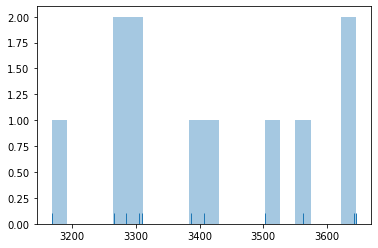

In [15]:
max_tweets_we_have = [ len(tweet) for tweet in user_to_tweet.values() ];
sns.distplot(max_tweets_we_have, bins=20, kde=False, rug=True);

#### so all have atleast 3000 tweets!

In [17]:
all_words = {}
for user in indian_news:
    for tweet in user_to_tweet[user]:
        text = tweet['text']
        for word in text.split(' '):
            try:
                all_words[word] = all_words[word] + 1
            except:
                all_words[word] = 1

In [18]:
total_tweets = sum( [len(tweet) for tweet in user_to_tweet.values()] )
print('Total tweets in our dataset are : %d' % (total_tweets) )
total_words = sum( [ all_words[word] for word in all_words.keys() ] )
print('Total words in our dataset are : %d' % (total_words) )
total_unique_words = len( all_words.keys() )
print('Total unique words in our dataset are : %d' % (total_unique_words))

Total tweets in our dataset are : 37483
Total words in our dataset are : 325515
Total unique words in our dataset are : 31433


In [19]:
tweets_corpus = [] #we add it in order of users we have in variable indian_news
for user in indian_news:
    all_user_tweets = [ tweet['text'] for tweet in user_to_tweet[user] ]
    tweet_corpus = ' '.join(all_user_tweets)
    tweets_corpus.append( tweet_corpus )

In [61]:
vectorizer = TfidfVectorizer(min_df=2, max_df=20, ngram_range=(1,2), norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)

In [62]:
tfidf_results = vectorizer.fit_transform(tweets_corpus)
# similarity matrix - how similar two users are! using fact that angle between them is very small
# note that vector for each user is normalized already, so we don't need to divide by norm of them to get cosine value
X = tfidf_results
similarity = (X * X.T).todense()
words = vectorizer.get_feature_names()
# Before we visualize it, let's quickly do some dirty check to find users closer to each other

In [63]:
close_users = []
limit = 0.8
for i in range(similarity.shape[0]):
    for j in range(similarity.shape[1]):
        if i == j:
            continue
        if similarity[i,j] > limit:
            pair = [ indian_news[i], indian_news[j] ]
            pair.sort()
            close_users.append('#'.join(pair))
close_users = [ x.split('#') for x in set(close_users) ]
close_users

[['PTI_News', 'TOIIndiaNews'], ['TOIIndiaNews', 'ThePrintIndia']]

In [64]:
# Time to visualize
tsne = TSNE( n_components=2, verbose=1, perplexity=40, n_iter=10000 )
tsne_results = tsne.fit_transform( similarity )

[t-SNE] Computing 10 nearest neighbors...
[t-SNE] Indexed 11 samples in 0.000s...
[t-SNE] Computed neighbors for 11 samples in 0.000s...
[t-SNE] Computed conditional probabilities for sample 11 / 11
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 92.124039
[t-SNE] KL divergence after 1450 iterations: 0.268366


[t-SNE] Computing 10 nearest neighbors...
[t-SNE] Indexed 11 samples in 0.000s...
[t-SNE] Computed neighbors for 11 samples in 0.000s...
[t-SNE] Computed conditional probabilities for sample 11 / 11
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.550076
[t-SNE] KL divergence after 1300 iterations: 0.268363


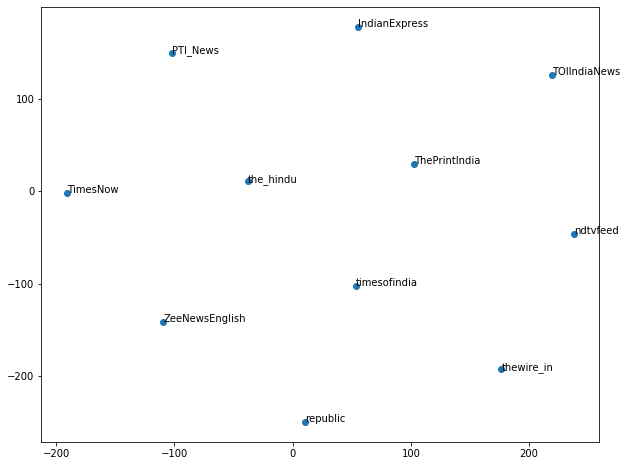

In [65]:
# Time to visualize
tsne = TSNE( n_components=2, verbose=1, perplexity=40, n_iter=10000 )
tsne_results = tsne.fit_transform( similarity )
X = tsne_results[:,0]
Y = tsne_results[:,1]
fig,ax = plt.subplots(1,1,figsize=(10,8))
ax.scatter(X,Y)
for i,user in enumerate(indian_news):
    ax.annotate(user, (X[i],Y[i]))  #this is not very easy to see...

#### Well, nothing to see here...
### Let's check what are top words that define these twitter accounts!

In [66]:
#all_users is sorted!
tfidf = tfidf_results.todense()
words_to_see = 15
user_to_words = {}
for i in range(len(indian_news)):
    user = indian_news[i]
    tfidf_value = [ [ tfidf[i][0,j], j ] for j in range(tfidf[i].shape[1]) ]
    tfidf_value.sort(reverse=True)
    mostImportantXWords = [ wd[1] for wd in tfidf_value[0:words_to_see] ]
    user_to_words[ user ] = mostImportantXWords

In [67]:
for user in indian_news:
    word_indices = user_to_words[user]
    words_ = [ words[i] for i in word_indices ]
    print(user,'\t',words_)

timesofindia 	 ['covid', 'nnread', 'case', 'lockdown', 'coronavirus', 'india', 'positive', 'state', 'death', 'new', 'say', 'today', 'amp', 'health', 'total']
republic 	 ['covid', 'lockdown', 'amid', 'coronavirus', 'wwe', 'say', 'watch', 'share', 'india', 'share view', 'nba', 'ipl', 'tune', 'amid covid', 'arnab']
thewire_in 	 ['india', 'government', 'said', 'delhi', 'coronavirus', 'people', 'covid', 'police', 'court', 'case', 'svaradarajan', 'minister', 'state', 'day', 'indian']
ndtvfeed 	 ['latest update', 'coronavirusoutbreak', 'update', 'latest', 'covid', 'lockdown', 'coronavirus', 'amid', 'india', 'delhi', 'case', 'pic', 'centre', 'minister', 'say']
ZeeNewsEnglish 	 ['coronavirus', 'covid', 'coronavirus covid', 'live', 'case', 'zee', 'india', 'zee news', 'lockdown', 'amid', 'pic', 'say', 'death', 'news', 'new']
PTI_News 	 ['covid', 'coronavirus', 'case', 'official', 'health', 'lockdown', 'rise', 'govt', 'state', 'test', 'positive', 'people', 'delhi', 'ministry', 'death']
TimesNow 	 

### OK!! It's largely related to coronavirus!! We need to get data past the 3000 tweets that twitter allows!!<br>Need to use something else to scrape the data from twitter.....will selenium work here? Will I need to write my own script to scrape data? Maybe there is some existing tool for it...